In [1]:
import torch
from torchmetrics import Accuracy
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
import numpy as np
torch.__version__

'2.4.0+rocm6.1'

Make a problem with 2 variables

In [25]:
from sklearn.datasets import make_circles

X, y = make_circles(1000, noise=0.1, random_state=23)
X,y[:10]

(array([[ 0.75921612,  0.12538944],
        [-0.4849095 , -0.57418448],
        [-0.915094  ,  0.46046701],
        ...,
        [ 0.84696809,  0.48985966],
        [-0.80217857,  0.18905475],
        [ 0.26813826,  0.84766116]]),
 array([1, 1, 0, 1, 1, 1, 1, 0, 1, 0]))

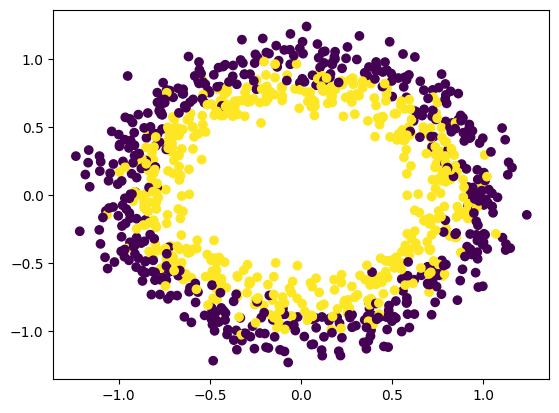

In [26]:
plt.scatter(X[:,0], X[:,1], c=y)

To pass data to a tensor

In [27]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [28]:
Xtv, Xts, ytv, yts = train_test_split(X, y, test_size= 0.2, random_state=23)
Xtv.shape, Xts.shape, ytv.shape, yts.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu" #To pass the data to the gpu if its available
device

'cuda'

In [30]:
class ClassifModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(in_features=2, out_features=5) #Its like neurons, enter the 2 features, make it 5
        self.layer_2 = nn.Linear(in_features=5, out_features=1) #Recieve 5 and make it 1
    def forward(self, x: torch.Tensor):
        return self.layer_2(self.layer_1(x)) #First the tensor pass from layer_2 and the layer_1

model = ClassifModel().to(device)
model

ClassifModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

If i want it sequential for sake of simplicity i can run

In [31]:
model_1 = nn.Sequential(
  nn.Linear(in_features=2, out_features=5),
  nn.Linear(in_features=5, out_features=1)
).to(device)

model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

The problem with this is that runs sequential, so if we want to do some steps before or after training we cant do it, for that is better to use a subclass approach 

In [32]:
loss_fn = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

Make a acurracy function

In [33]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() #eq is the built in function to see if 2 tensors are equal
    return (correct / len(y_pred)) * 100

Example

In [34]:
torch.eq(torch.tensor([2, 1, 1]),torch.tensor([2, 2, 1])).sum().item()

2

Understanding how the model pass the data and how interpreter it, if we pass the raw data to the model we get something like this

In [35]:
y_pred = model_1(Xtv.to(device))
y_pred[:10]

tensor([[-0.1029],
        [-0.0271],
        [-0.3621],
        [-0.4637],
        [-0.1356],
        [-0.5281],
        [-0.5147],
        [-0.4111],
        [-0.1380],
        [-0.3734]], device='cuda:0', grad_fn=<SliceBackward0>)

So we use a function to interpreter those values called logits

In [36]:
y_pred = torch.sigmoid(y_pred)
y_pred[:10]

tensor([[0.4743],
        [0.4932],
        [0.4104],
        [0.3861],
        [0.4662],
        [0.3710],
        [0.3741],
        [0.3986],
        [0.4656],
        [0.4077]], device='cuda:0', grad_fn=<SliceBackward0>)

Its seems more like a probability being a class or another

In [37]:
y_pred = torch.round(y_pred.to(device))

print(torch.eq(y_pred, ytv.to(device))[:5])
y_pred.squeeze()[:5] # To make it a row

tensor([[ True, False,  True,  ..., False, False,  True],
        [ True, False,  True,  ..., False, False,  True],
        [ True, False,  True,  ..., False, False,  True],
        [ True, False,  True,  ..., False, False,  True],
        [ True, False,  True,  ..., False, False,  True]], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SliceBackward0>)

In [15]:
def train_funcion(model, optimizer, accuracy=accuracy, multi=False, loss_fn=loss_fn, epochs=1000, device=device, 
                  Xtv=Xtv, ytv= ytv, Xts=Xts, yts=yts):
    Xtv, Xts, ytv, yts = Xtv.to(device), Xts.to(device), ytv.to(device), yts.to(device) 
    for epoch in range(epochs):
        model.train()
        if multi:
            y_logits = model(Xtv)
        else:
            y_logits = model(Xtv).squeeze()
        loss = loss_fn(y_logits, ytv)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.eval()
        with torch.inference_mode():
            if epoch % 200 == 0:
                if multi:
                    y_logits = model(Xts)
                    y_pred = torch.softmax(y_logits, 1).argmax(1)
                else:
                    y_logits = model(Xts).squeeze()
                    y_pred = torch.round(torch.sigmoid(y_logits))
                loss = loss_fn(y_logits, yts)
                acc = accuracy(yts, y_pred) * 100
        
        if epoch % 200 == 0:
            print(f"Epoch {epoch} | loss {loss} | acurracy {acc}")
    return model

In [39]:
list(model_1.parameters())

[Parameter containing:
 tensor([[-0.4658, -0.2655],
         [-0.4277,  0.0659],
         [-0.6770,  0.5726],
         [ 0.4871,  0.6123],
         [-0.2899, -0.0321]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0301, -0.2206,  0.2449,  0.2253, -0.4414], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([[-0.0406, -0.3534,  0.1889,  0.2423,  0.0460]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([-0.3750], device='cuda:0', requires_grad=True)]

In [40]:
torch.manual_seed(23)
epochs = 1000
model_1 = train_funcion(model_1,optimizer, epochs=epochs)

Epoch 0 | loss 0.7094396948814392 | acurracy 38.5
Epoch 200 | loss 0.6974326372146606 | acurracy 43.5
Epoch 400 | loss 0.6975520253181458 | acurracy 44.5
Epoch 600 | loss 0.6975682377815247 | acurracy 44.5
Epoch 800 | loss 0.6975701451301575 | acurracy 44.5


In [41]:
list(model_1.parameters())

[Parameter containing:
 tensor([[-0.4701, -0.2790],
         [-0.3699,  0.1793],
         [-0.7095,  0.5097],
         [ 0.4622,  0.5709],
         [-0.2946, -0.0412]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0275, -0.2829,  0.2798,  0.2549, -0.4360], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([[ 0.1141, -0.3714,  0.1758,  0.0233,  0.0283]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([-0.2003], device='cuda:0', requires_grad=True)]

In [13]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    model.to(device)
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    

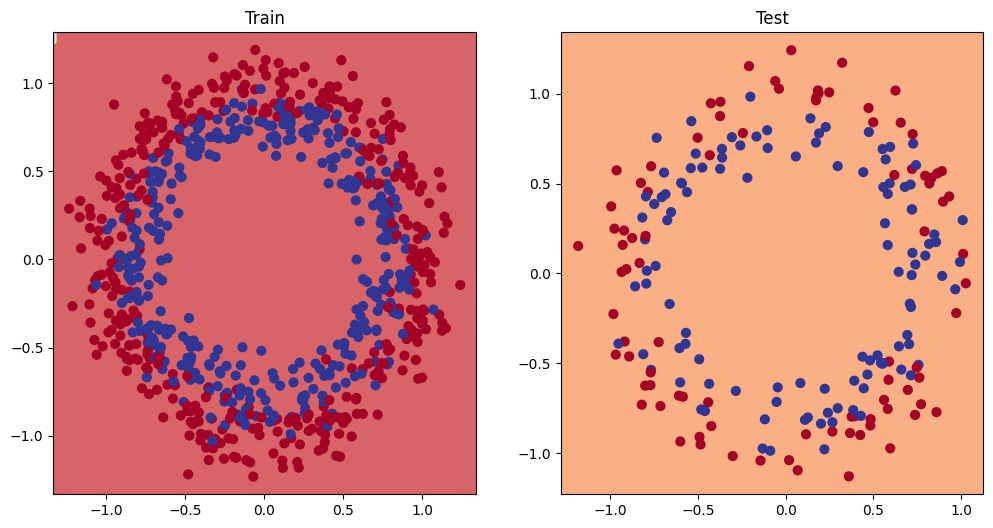

In [43]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, Xtv, ytv)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, Xts, yts)

### Add non linearity

With a activation function

In [44]:
class ClassifModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(in_features=2, out_features=16) #Its like neurons, enter the 2 features, make it 5
        self.layer_2 = nn.Linear(in_features=16, out_features=16) #Recieve 5 and make it 1
        self.layer_3 = nn.Linear(in_features=16, out_features=1) #Recieve 5 and make it 1
        self.relu = nn.ReLU()
    def forward(self, x: torch.Tensor):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))) #First the tensor pass from layer_2 and the layer_1

model_3 = ClassifModel().to(device)
model_3

ClassifModel(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

In [45]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [46]:
torch.manual_seed(23)
epochs = 1000
train_funcion(model_3,optimize, epochs=epochs)

Epoch 0 | loss 0.7034926414489746 | acurracy 44.5
Epoch 200 | loss 0.6956318020820618 | acurracy 50.5
Epoch 400 | loss 0.6904233694076538 | acurracy 54.50000000000001
Epoch 600 | loss 0.6710608005523682 | acurracy 57.99999999999999
Epoch 800 | loss 0.6258395910263062 | acurracy 67.0


ClassifModel(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

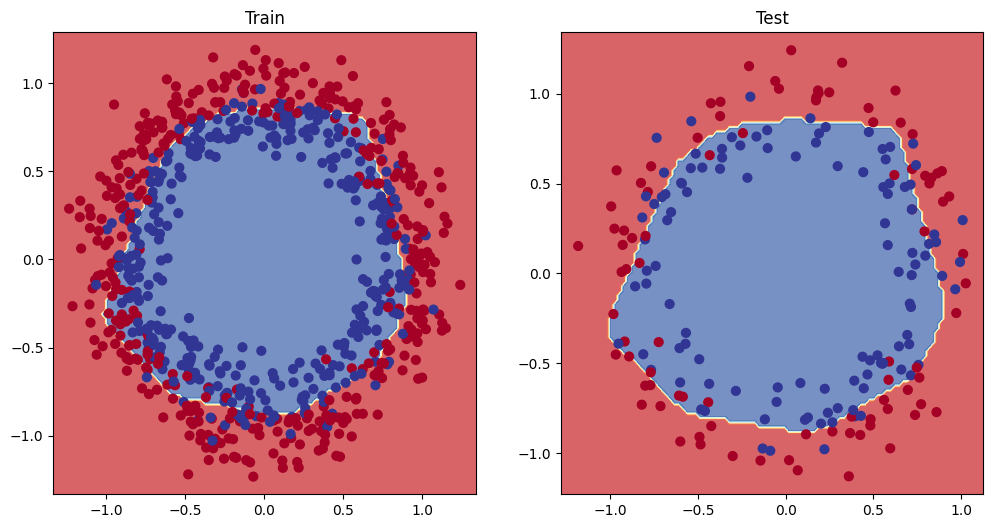

In [47]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, Xtv, ytv)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, Xts, yts)

In [48]:
class ClassifModel3(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(in_features=2, out_features=16) #Its like neurons, enter the 2 features, make it 5
        self.layer_2 = nn.Linear(in_features=16, out_features=16) #Recieve 5 and make it 1
        self.layer_3 = nn.Linear(in_features=16, out_features=1) #Recieve 5 and make it 1
        self.sigmoid = nn.Sigmoid()
    def forward(self, x: torch.Tensor):
        return self.layer_3(self.sigmoid(self.layer_2(self.sigmoid(self.layer_1(x))))) #First the tensor pass from layer_2 and the layer_1

model_4 = ClassifModel3().to(device)
model_4

ClassifModel3(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [49]:
optimizer = torch.optim.Adam(params=model_4.parameters(), lr=0.1)

In [50]:
torch.manual_seed(23)
epochs = 1000
train_funcion(model_4,optimizer)

Epoch 0 | loss 0.6964057087898254 | acurracy 55.50000000000001
Epoch 200 | loss 0.4619350731372833 | acurracy 80.0
Epoch 400 | loss 0.4714169502258301 | acurracy 81.5
Epoch 600 | loss 0.48444926738739014 | acurracy 82.5
Epoch 800 | loss 0.501185953617096 | acurracy 80.5


ClassifModel3(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

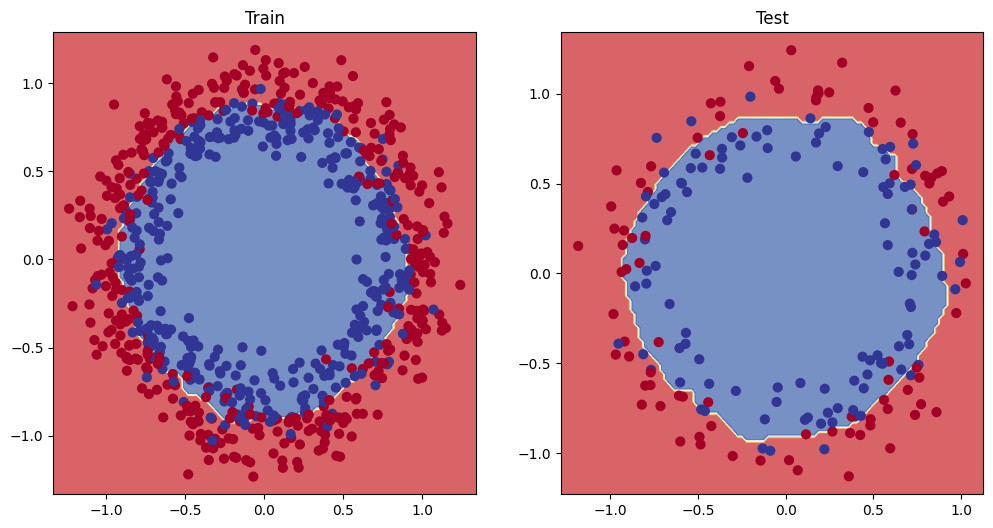

In [51]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, Xtv, ytv)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, Xts, yts)

### For multiclass problems

In [52]:
from sklearn.datasets import make_blobs

X_blob , y_blob = make_blobs(
    1000, 2, centers=4, cluster_std=1, random_state=23
)

X = torch.from_numpy(X_blob).type(torch.float)
y = torch.from_numpy(y_blob).type(torch.LongTensor)

Xtv, Xts, ytv, yts = train_test_split(X, y, test_size= 0.2, random_state=23)
Xtv.shape, Xts.shape, ytv.shape, yts.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

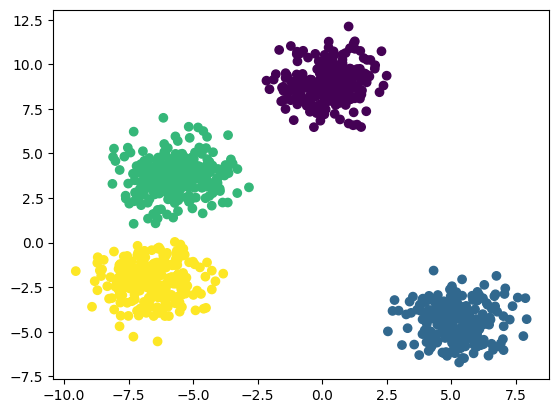

In [53]:
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob)

In [54]:
class BloobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 10,*args, **kwargs):
        super().__init__(*args, **kwargs)
        self.linear_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_features)
        )
    def forward(self, x: torch.Tensor):
        return self.linear_stack(x)

model_5 = BloobModel(2, 4).to(device)
model_5

BloobModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [55]:
loss_fn = nn.CrossEntropyLoss() #Remember to change the loss function for each problem
optimizer = torch.optim.SGD(model_5.parameters(), lr=0.01)

In [57]:
model_5(Xtv.to(device))[:5]

tensor([[ 0.1199, -0.4989,  0.0295,  0.3339],
        [ 0.0898, -0.3350, -0.1626,  0.7004],
        [ 0.0588, -0.3487, -0.1905,  0.6928],
        [-0.7834, -0.1073,  0.1961,  0.6429],
        [-0.0982, -0.3692, -0.2386,  0.6251]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In multiclass problems we use the softmax to interpreter the results, remember to do like: logits(raw data from the model) - prediction probabilities - prediction labels

In [59]:
y_logits = model_5(Xtv.to(device))

y_pred_probs = torch.softmax(y_logits, 1)
print(y_pred_probs[:5])

tensor([[0.2709, 0.1459, 0.2475, 0.3356],
        [0.2341, 0.1531, 0.1819, 0.4310],
        [0.2310, 0.1537, 0.1800, 0.4354],
        [0.1021, 0.2008, 0.2720, 0.4251],
        [0.2131, 0.1625, 0.1852, 0.4392]], device='cuda:0',
       grad_fn=<SliceBackward0>)


To extract the class of those possibilities we need to see what is the most probable label

In [60]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.2709, 0.1459, 0.2475, 0.3356], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


If theres a problem from long tensor or float just change the data type

In [65]:
train_funcion(model_5, optimizer, multi=True,epochs=epochs)

Epoch 0 | loss 0.017390960827469826 | acurracy 100.0
Epoch 200 | loss 0.012920493260025978 | acurracy 100.0
Epoch 400 | loss 0.010274950414896011 | acurracy 100.0
Epoch 600 | loss 0.008534574881196022 | acurracy 100.0
Epoch 800 | loss 0.007309043779969215 | acurracy 100.0


BloobModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

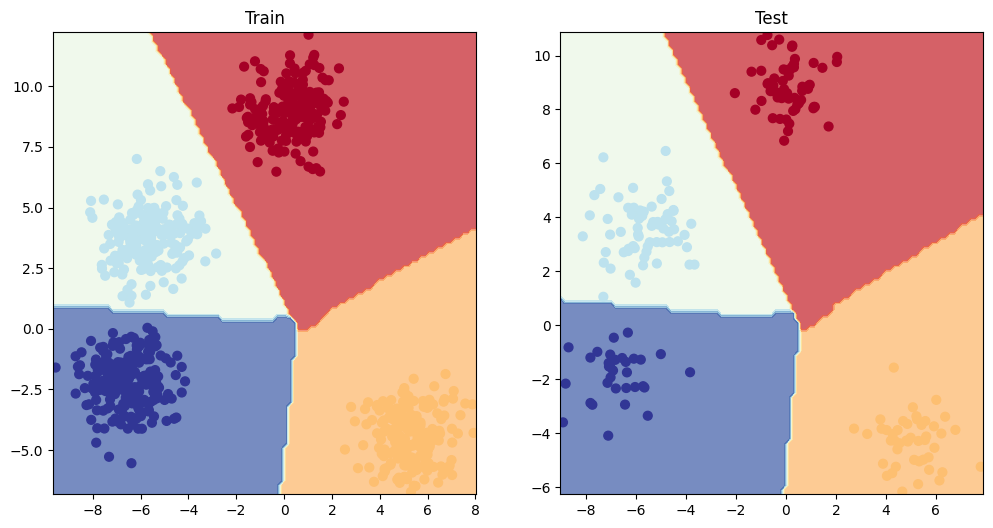

In [66]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_5, Xtv, ytv)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_5, Xts, yts)

Withouth ReLu

In [67]:
class BloobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 10,*args, **kwargs):
        super().__init__(*args, **kwargs)
        self.linear_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            #nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            #nn.ReLU(),
            nn.Linear(hidden_units, output_features)
        )
    def forward(self, x: torch.Tensor):
        return self.linear_stack(x)

model_6 = BloobModel(2, 4).to(device)
model_6

BloobModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [68]:
loss_fn = nn.CrossEntropyLoss() #Remember to change the loss function for each problem
optimizer = torch.optim.SGD(model_6.parameters(), lr=0.01)

In [69]:
train_funcion(model_6, optimizer, multi=True, epochs=epochs)

Epoch 0 | loss 1.0213122367858887 | acurracy 62.5
Epoch 200 | loss 0.0598161555826664 | acurracy 100.0
Epoch 400 | loss 0.027802614495158195 | acurracy 100.0
Epoch 600 | loss 0.01808771677315235 | acurracy 100.0
Epoch 800 | loss 0.013480769470334053 | acurracy 100.0


BloobModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=4, bias=True)
  )
)

### Validate the acurracy and loss with the test data

In [71]:
model_6.eval()
with torch.inference_mode():
    y_logits = model_6(Xtv.to(device))
y_pred_probs = torch.softmax(y_logits, 1)
y_pred = y_pred_probs.argmax(1)

print(f"Loss {loss_fn(y_logits, ytv.to(device))} Accuracy {acurracy(ytv.to(device), y_pred)}")

Loss 0.009237590245902538 Accuracy 100.0


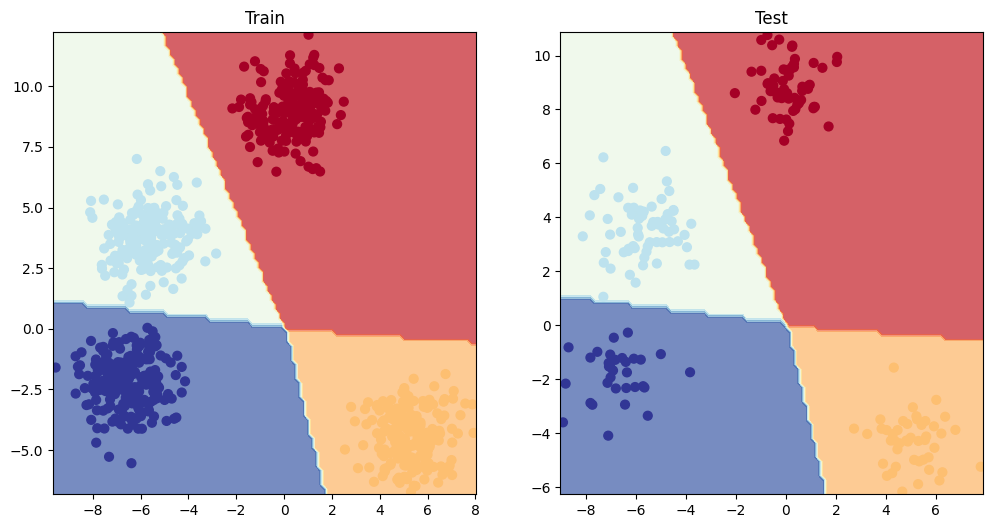

In [72]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_6, Xtv, ytv)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_6, Xts, yts)

### Now with make moons

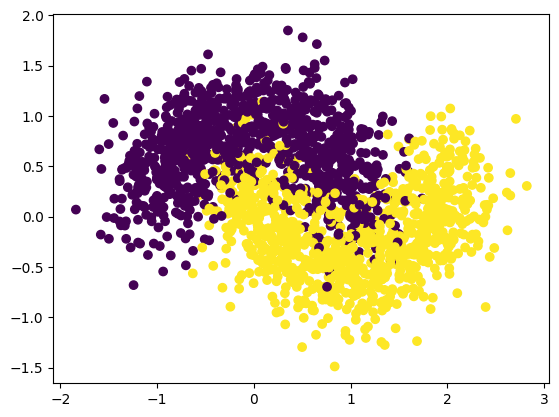

In [159]:
from sklearn.datasets import make_moons

X, y = make_moons(2000, random_state=23, noise=0.3)

plt.scatter(X[:,0], X[:,1],c=y)

In [160]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [161]:
Xtv, Xts, ytv, yts = train_test_split(X, y, train_size=0.8, random_state=23)
Xtv.shape, Xts.shape, ytv.shape, yts.shape

(torch.Size([1600, 2]),
 torch.Size([400, 2]),
 torch.Size([1600]),
 torch.Size([400]))

In [162]:
accuracy = Accuracy(task="binary").to(device)

In [167]:
class BinaryMoons(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.sequential_layer = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Sigmoid(),
            nn.Linear(32, 1),
        )
    def forward(self, x:torch.Tensor):
        return self.sequential_layer(x)

model_7 = BinaryMoons().to(device)
model_7

BinaryMoons(
  (sequential_layer): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [168]:
loss_fn = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model_7.parameters(), lr=0.1)

In [170]:
torch.manual_seed(23)
epochs = 3000
train_funcion(model_7, optimizer, accuracy, loss_fn=loss_fn, epochs=epochs)
list(model_7.parameters())

Epoch 0 | loss 0.4555169939994812 | acurracy 87.0
Epoch 200 | loss 0.3874344527721405 | acurracy 89.0
Epoch 400 | loss 0.4591662585735321 | acurracy 90.5
Epoch 600 | loss 0.5532733201980591 | acurracy 88.5
Epoch 800 | loss 0.5290160179138184 | acurracy 89.0
Epoch 1000 | loss 0.5263005495071411 | acurracy 90.0
Epoch 1200 | loss 0.4788471460342407 | acurracy 88.0
Epoch 1400 | loss 0.40011587738990784 | acurracy 89.0
Epoch 1600 | loss 0.3639066219329834 | acurracy 88.5
Epoch 1800 | loss 0.4248340427875519 | acurracy 89.0
Epoch 2000 | loss 0.4533834755420685 | acurracy 89.0
Epoch 2200 | loss 0.4407563805580139 | acurracy 89.0
Epoch 2400 | loss 0.4165484607219696 | acurracy 90.0
Epoch 2600 | loss 0.38793525099754333 | acurracy 88.5
Epoch 2800 | loss 0.3564198315143585 | acurracy 87.5


[Parameter containing:
 tensor([[ -2.1596,  -0.2893],
         [ -6.8272,  -8.2429],
         [  4.2173,  -9.7149],
         [ -9.1829,   2.2637],
         [  3.7680,  -1.1072],
         [  8.7129,  -2.4482],
         [  1.2535,  35.7678],
         [  0.6150,   2.4266],
         [ -4.8424,  -1.0646],
         [  3.8703,  -6.8848],
         [  6.9797,   2.6654],
         [ -0.0818,  -3.0434],
         [  4.7771,  -5.1264],
         [ -2.3725,  32.3385],
         [  4.8233,  -4.6482],
         [  7.1806,   7.5989],
         [ -0.9420,   1.1206],
         [ 12.3294,  -4.9954],
         [  3.0538,  -0.1311],
         [-13.3483,   0.2126],
         [ -0.5571,  -6.9814],
         [ -3.1606,   3.0326],
         [ -3.4765,   2.3368],
         [ -5.2502,   3.4393],
         [ -4.2441,   3.0373],
         [ -7.1697, -12.7606],
         [  4.0997,   7.4544],
         [  6.3561,   6.1511],
         [  9.5507,  -0.9397],
         [  3.7709,  -1.0507],
         [ -8.6979,   1.2732],
         [  5.54

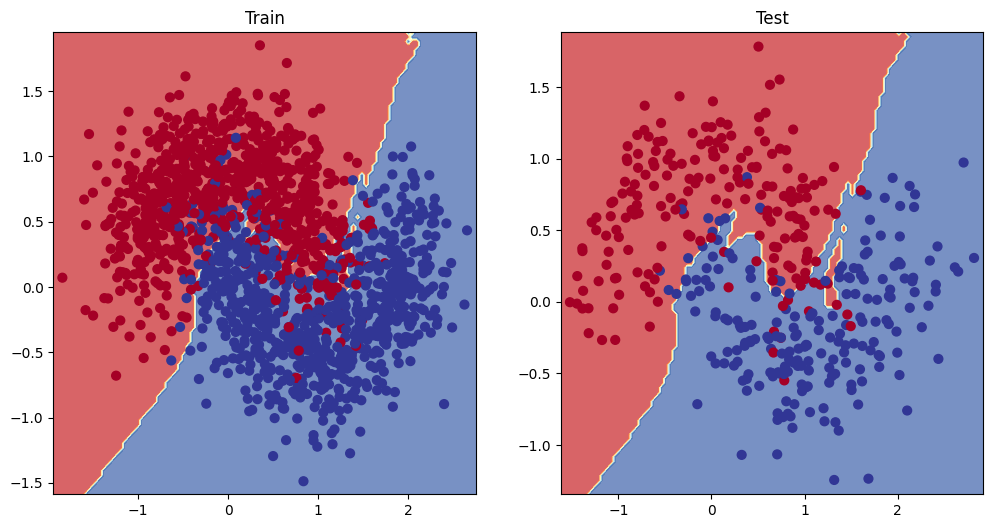

In [171]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_7, Xtv, ytv)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_7, Xts, yts)

CS321n Training data

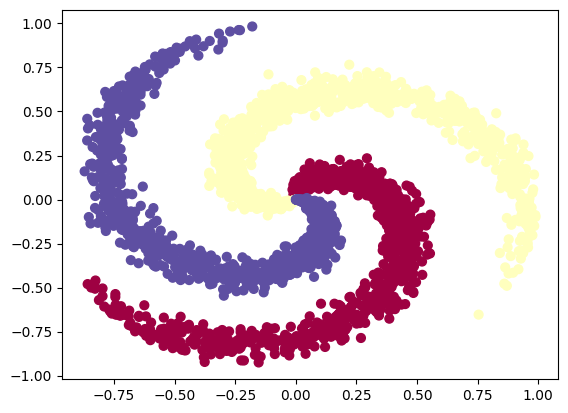

In [137]:
N = 1000 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [138]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

In [139]:
X.shape

torch.Size([3000, 2])

In [140]:
Xtv, Xts, ytv, yts = train_test_split(X, y, train_size=0.8, random_state=23)

In [141]:
class Cs321nModel(nn.Module):
    def __init__(self,input_layer, output_layer, hidden_layers = 20, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.sequiential_layer = nn.Sequential(
            nn.Linear(input_layer,hidden_layers),
            nn.Tanh(),
            nn.Linear(hidden_layers,hidden_layers),
            nn.Tanh(),
            nn.Linear(hidden_layers,output_layer)
        )
    def forward(self, x:torch.Tensor):
        return self.sequiential_layer(x)
model_8 = Cs321nModel(2, 4).to(device)
model_8

Cs321nModel(
  (sequiential_layer): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=4, bias=True)
  )
)

In [142]:
accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

In [143]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_8.parameters(), lr= 0.1)

In [144]:
torch.manual_seed(23)
epochs = 3000
Xtv, Xts, ytv, yts = Xtv.to(device), Xts.to(device), ytv.to(device), yts.to(device)

for epoch in range(epochs):
    model_8.train()
    y_logits = model_8(Xtv)
    loss = loss_fn(y_logits, ytv)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_8.eval()
    if epoch % 200 == 0:
        with torch.inference_mode():
            y_logits = model_8(Xts)
            y_pred = torch.softmax(y_logits, 1).argmax(1)
            loss = loss_fn(y_logits, yts)
            acc = accuracy(y_pred, yts)
        print(f"loss {loss} | accuracy {acc * 100}")

loss 1.0601025819778442 | accuracy 45.66666793823242
loss 0.012552911415696144 | accuracy 99.5
loss 0.012042660266160965 | accuracy 99.5
loss 0.009966779500246048 | accuracy 99.5
loss 0.0062851677648723125 | accuracy 99.66666412353516
loss 0.006978157442063093 | accuracy 99.66666412353516
loss 0.009416940622031689 | accuracy 99.5
loss 0.010999059304594994 | accuracy 99.5
loss 0.01192223746329546 | accuracy 99.5
loss 0.01262679137289524 | accuracy 99.5
loss 0.013316617347300053 | accuracy 99.5
loss 0.013929362408816814 | accuracy 99.5
loss 0.014394447207450867 | accuracy 99.5
loss 0.014728652313351631 | accuracy 99.5
loss 0.014950104989111423 | accuracy 99.5


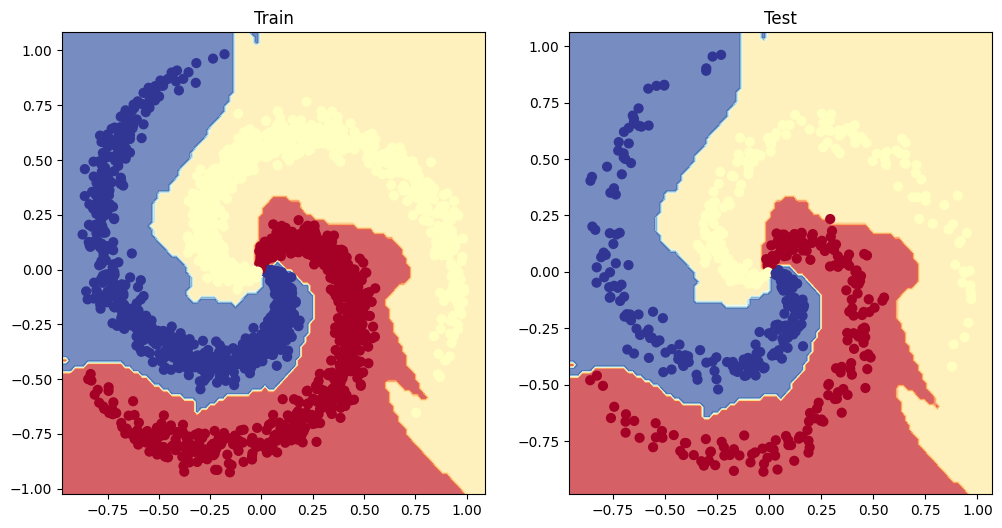

In [145]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_8, Xtv, ytv)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_8, Xts, yts)